# Random Walk Generation

Recall that the stochastic model for asset returns is given by the Geometric Brownian Motion process:

$$ \frac{S_{t+dt}-S_t}{S_t} = \mu dt + \sigma\sqrt{dt}\xi_t $$

Where 

$$ \mu = r + \sigma \lambda^s $$

When we generate simulated returns, we can usually ignore the decomposition of $\mu$ since we only care about the net effective drift term without worrying about what the components of it are.

The implementation is really very close to the equation above, although it can be optimized using numpy random normal distribution generator. 

In [27]:
import numpy as np
import pandas as pd
from random import uniform
import kit as erk

%matplotlib inline

In [7]:
# brownian motion generator
def gbm(years = 10, scenarios = 1000, mu = 0.07, sigma = 0.15, steps_per_year = 12, S0 = 100.0):
    """
    Evolution of Geometric Brownian Motion trajectories, such as for Stock Prices.

    Parameters:
        years:  The number of years to generate data for
        scenarios: The number of different scenarios/trajectories
        mu: Annualized Drift, e.g. Market Return
        sigma: Annualized Volatility
        steps_per_year: granularity of the simulation; periods per year
        s_0: initial value

    Return: 
        Array of amount of scenarios Columns and years*steps_per_year Rows
    """

    dt = 1/steps_per_year ;  n_steps = int(years*steps_per_year)

    # Returns in R+1 format                      drift; dist. mean       scalar operating on \xi_t
    rets_plus_1 =              np.random.normal( loc = (mu*dt + 1),      scale = ( sigma* dt**0.5 ),    size = (n_steps +1 , scenarios ) )
    rets_plus_1[0] = 1

    prices = S0 * pd.DataFrame(rets_plus_1).cumprod()
    return prices


In [14]:
prices = gbm(10, 10)

print( prices.iloc[-1].mean(), 100*1.07**10, sep = ' | ' )
prices.head()

211.47499340530794 | 196.71513572895665


,0,1,2,3,4,5,6,7,8,9
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,110.292738,102.630233,100.997247,104.849144,104.622357,100.606185,106.827954,99.251559,97.015616,96.590142
2,105.003435,101.163738,99.737625,103.399627,104.663508,96.045695,105.701088,94.850120,102.121089,91.875798
3,103.465811,97.443725,106.422841,105.818597,114.795682,99.005720,100.427729,91.990200,101.767687,93.599116
4,105.009844,101.235035,110.386223,102.587759,116.530572,100.059655,103.330196,92.847446,103.240589,83.489846


<Axes: >

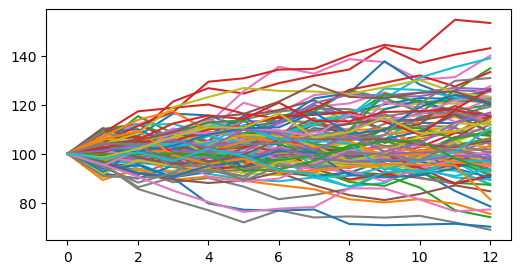

In [23]:
gbm(1, 100, 0.07).plot( legend= False, figsize= (6,3) )

## Upward Bias

We notice that the prices are slightly, but consistently biased upwards.


In [47]:
mus = [ uniform(0, 0.1) for i in range(3) ]
lst = []
for mu in mus:
 brownian = gbm(10, 10, mu).iloc[-1].mean()
 avg = 100 * (1 + mu)**10
 diff = (brownian - avg)

 lst.append( (brownian, avg, diff) )

lst

[(189.9508909101017, 176.91417895672592, 13.036711953375772),
 (142.83041251009413, 131.31853732133754, 11.51187518875659),
 (275.0102607900621, 249.8067595487298, 25.203501241332305)]

To fix the bias, we can adjust the expected return component, treating them as periodic prices.
```python
loc = (1 + mu)**dt
```

In [49]:
def gbm1(n_years = 10, n_scenarios= 1000, mu= 0.07, sigma= 0.15, steps_per_year= 12, S0= 100.0, prices = False):
    dt = 1/steps_per_year ;  n_steps = int(n_years*steps_per_year) + 1

    rets_plus_1 = np.random.normal(loc= ( 1 + mu )**dt, scale=(sigma*np.sqrt(dt)), size=(n_steps + 1, n_scenarios))
    rets_plus_1[0] = 1

                                                                # Raw Returns
    res = S0*pd.DataFrame(rets_plus_1).cumprod() if prices else (rets_plus_1 - 1)
    return res


gbm1().iloc[-1].mean(), 100*1.07**10

(191.86730184600518, 196.71513572895665)

In [ ]:
%timeit erk.gbm(n_years=5, n_scenarios=1000, mu=0.07)

1.46 ms ± 7.41 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
